  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.58154 | Train accuracy: 79.00%
Test loss: 0.37373 | Test accuracy: 86.41%

Epoch: 1
---------
Train loss: 0.34622 | Train accuracy: 87.50%
Test loss: 0.39677 | Test accuracy: 85.75%

Epoch: 2
---------
Train loss: 0.31149 | Train accuracy: 88.76%
Test loss: 0.32144 | Test accuracy: 88.35%

Train time on cuda: 51.689 seconds
{'model_name': 'FashionMNISTModelV2', 'model_loss': 0.32143521308898926, 'model_acc': 88.34864217252397}


Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

C:\Users\sRjN\AppData\Local\Temp\ipykernel_21932\1884167462.py:116: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


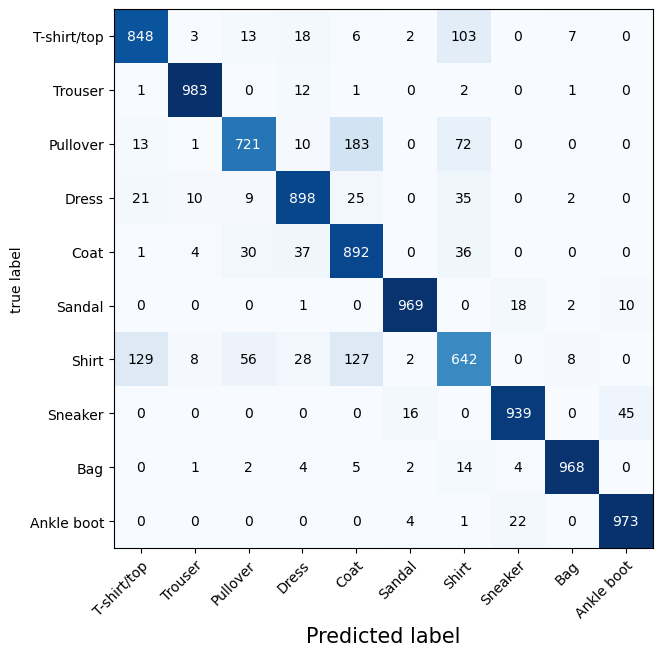

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from helper import accuracy_fn
from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"


def main():
    BATCH_SIZE = 32

    # Download training data from open datasets.
    # Setup training data
    train_data = datasets.FashionMNIST(
        root="data",  # where to download data to?
        train=True,  # get training data
        download=True,  # download data if it doesn't exist on disk
        transform=ToTensor(),  # images come as PIL format, we want tensors
        target_transform=None,  # you can transform labels as well
    )
    class_names = train_data.classes
    # Setup testing data
    test_data = datasets.FashionMNIST(
        root="data", train=False, download=True, transform=ToTensor()
    )

    # Turn datasets into iterables (batches)
    train_dataloader = DataLoader(
        train_data,  # dataset to turn into iterable
        batch_size=BATCH_SIZE,  # how many samples per batch?
        shuffle=True,  # shuffle data every epoch?
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=BATCH_SIZE,
        shuffle=False,  # don't necessarily have to shuffle the testing data
    )

    model_2 = FashionMNISTModelV2(
        input_shape=1, hidden_units=10, output_shape=len(class_names)
    ).to(device)
    # Setup loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

    train_time_start_model_2 = timer()

    # Train and test model
    epochs = 3
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n---------")
        train_step(
            data_loader=train_dataloader,
            model=model_2,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device,
        )
        test_step(
            data_loader=test_dataloader,
            model=model_2,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device,
        )

    train_time_end_model_2 = timer()
    print_train_time(
        start=train_time_start_model_2, end=train_time_end_model_2, device=device
    )
    model_2_results = eval_model(
        model=model_2,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
    )
    print(model_2_results)
    # torch.save(model_2.state_dict(), "models/model_2.pth")
    y_preds = []

    model_2.eval()
    with torch.inference_mode():
        for X, y in tqdm(test_dataloader, desc="Making predictions"):
            # Send data and targets to target device
            X, y = X.to(device), y.to(device)
            # Do the forward pass
            y_logit = model_2(X)
            # Turn predictions from logits -> prediction probabilities -> predictions labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(
                dim=1
            )  # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
            # Put predictions on CPU for evaluation
            y_preds.append(y_pred.cpu())
    # Concatenate list of predictions into a tensor
    y_pred_tensor = torch.cat(y_preds)
    confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")

    confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

    # 3. Plot the confusion matrix
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),  # matplotlib likes working with NumPy
        class_names=class_names,  # turn the row and column labels into class names
        figsize=(10, 7),
    )
    ax.set_xlabel("Predicted label", fontsize=15)
    fig.show()


# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,  # how big is the square that's going over the image?
                stride=1,  # default
                padding=1,  # options = "valid" (no padding) or "same"
                # (output has same shape as input) or int for specific number
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, stride=2
            ),  # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses
            # and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x


def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device,
):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(
            y_true=y, y_pred=y_pred.argmax(dim=1)
        )  # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(
    data_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    accuracy_fn: torch.nn.Module = accuracy_fn,
    device: torch.device = device,
):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()  # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(
                y_true=y,
                y_pred=test_pred.argmax(dim=1),
                # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time


def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device,
):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {
        "model_name": model.__class__.__name__,  # only works when model was created with a class
        "model_loss": loss.item(),
        "model_acc": acc,
    }


if __name__ == "__main__":
    main()